In [1]:
!pip install --upgrade pymc3
!pip install arviz

Requirement already up-to-date: pymc3 in /usr/local/lib/python3.6/dist-packages (3.8)


In [0]:
import pymc3 as pm
import arviz as az
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [0]:
import numpy as np
from sklearn import datasets
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

## Changing point detection

Одна из возможных задач, которые могут возникать при анализе временных рядов - это так называемое определение поворотных точек (changing point detection). В трейдинге, например, на таких поворотных точках можно строить стратегии и зарабатывать миллионы. В экономике вообще можно так анализировать последствия всяких политик. Но это если про деньги и скучно. Давайте про жизнь:)

Допустим, вы познакомились с мальчиком, все идет отлично, смайлики, кошечки, собачки, сообщения летят без остановки. Проходит время, и что-то вам стало казаться что пожар погас. Но мы же не с филфака девочки, вообще много теперь всего знаем и можем провести расследование. Можем?
Соберем данные и выясним а погас ли, а если погас то когда, а насколько точно погас, можем ли разжечь выяснять не будем:)

Вот вам данные, надо выяснить!

In [4]:
with pm.Model() as messages:
    text = pm.Poisson("mu", 10)
    trace = pm.sample(365)

Only 365 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [mu]
Sampling chain 1, 0 divergences: 100%|██████████| 865/865 [00:00<00:00, 9747.22it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [5]:
trace['mu']

array([ 7, 11, 11, 11,  9,  9, 11, 11, 12, 12, 12, 12,  9,  9, 13, 13, 12,
       10, 10, 10, 10, 10, 10, 10,  7,  7,  7,  7, 10, 10,  9, 13, 13, 11,
       11, 10,  7,  7,  7,  6,  6, 11,  8,  8,  8, 10, 10, 12, 13, 13,  7,
       13, 16, 16, 17, 17, 15, 11, 10,  9,  9,  7, 12, 12, 12, 11, 11, 14,
        9,  9,  9,  9,  5,  5,  5,  5, 16, 14, 11, 12, 12, 10,  8,  5,  8,
       13, 10, 10, 11, 11, 11, 11, 10, 10, 10, 11, 11, 11, 10, 10, 10, 10,
       10, 13, 13, 11, 11, 11,  8,  8,  8,  6, 11, 12,  9,  9, 18, 18, 14,
       18, 10, 10, 10,  9,  9,  9,  9,  8,  7,  7,  7,  6, 10,  8,  9,  8,
       10, 10, 10, 13, 13, 11, 15, 15, 15, 16, 15, 15, 11,  9,  6,  6,  7,
       11, 11, 11, 15, 15, 13, 13, 13, 13, 16, 16, 16, 16, 22, 22, 22, 21,
       23, 20, 17, 15, 14, 10, 10,  8,  8, 17, 11, 11, 11, 13, 13, 12, 13,
       12, 12, 12, 12, 10, 13,  8,  8, 13, 13, 14, 15, 10,  5,  5,  5,  5,
       10, 10,  8,  8,  8,  8, 10,  7,  6, 11, 13, 13, 13, 13,  8,  8,  8,
        7,  7,  6,  5,  8

In [6]:
with pm.Model() as messages:
    text = pm.Poisson("mu", 10)
    tau1 = pm.DiscreteUniform('tau1', 0, 100)
    trace = pm.sample(1000)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau1]
>Metropolis: [mu]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:00<00:00, 4602.03it/s]
The number of effective samples is smaller than 25% for some parameters.


In [7]:
trace['tau1']

array([35, 67, 31, ..., 95, 95, 95])

In [0]:
def generate_number(mu1, mu2, tau = 480, N = 1000):
    text1 = stats.poisson(mu1).rvs(tau)
    text2 = stats.poisson(mu2).rvs(N-tau)
    return pd.DataFrame(np.hstack((text1,text2)), columns=['number'])

In [9]:
df = generate_number(15, 12, tau = 48, N = 100)
df.head()

,number
0,16
1,17
2,21
3,13
4,14


In [10]:
df.shape[0], df.number.mean()

(100, 14.64)

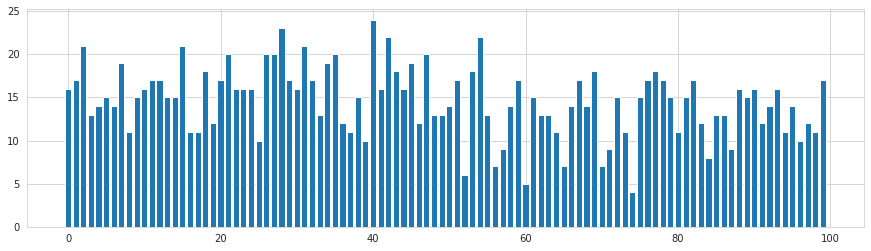

In [11]:
plt.figure(figsize = (15,4))
plt.bar(df.index[:100],df.number);

In [12]:
with pm.Model() as chPoint:
    len_data = df.shape[0]
    mean_data = df.number.mean()
    #можно и так например
    mu1 = pm.Exponential('mu1', 1/mean_data)
    mu2 = pm.Exponential('mu2', 1/mean_data)
    #alpha = 1./15.

    #lam1, lam2 = np.random.exponential(scale=1/alpha, size=2)

    tau = pm.DiscreteUniform('tau', 0, len_data - 1)
    idx = np.arange(len_data) # Index
    #lambda_ = pm.Deterministic('lam_',pm.math.switch(tau > idx, lam1, lam2))
    mu_ = pm.math.switch(tau > idx, mu1, mu2)
    y = pm.Poisson("y", mu_, observed=df.number)
    trace_chPoint = pm.sample(2000)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [mu2, mu1]
>Metropolis: [tau]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:01<00:00, 1301.74it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


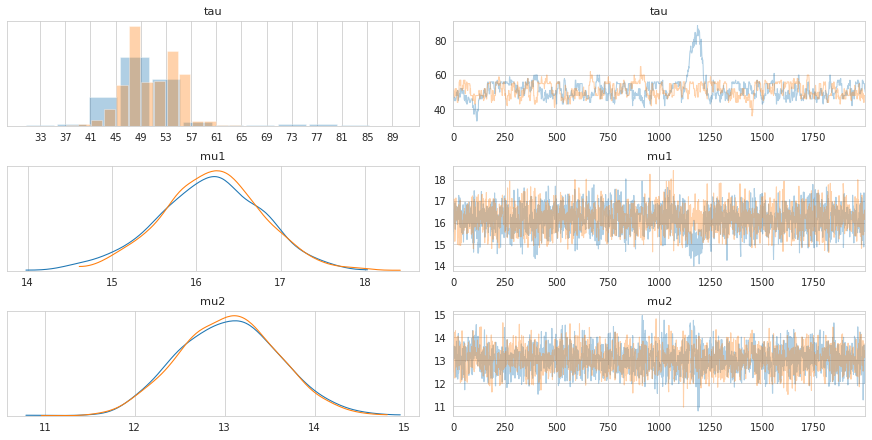

In [13]:
#varnames = ['~lam_']
az.plot_trace(trace_chPoint);

# А теперь немножко данных про которые мы не знаем

In [0]:
messages = pd.read_csv("https://raw.githubusercontent.com/iknyazeva/BayesData/master/txtdata.csv", header=None, names = ["number"])

In [15]:
messages.head()

,number
0,13.0
1,24.0
2,8.0
3,24.0
4,7.0


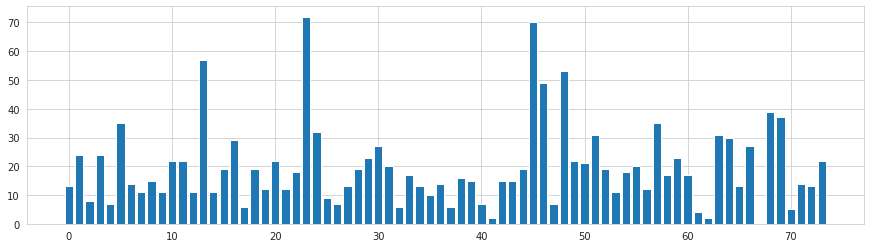

In [16]:
plt.figure(figsize = (15,4))
plt.bar(messages.index, messages.number);

Какие тут параметры?

In [17]:
df = messages
df.head()

,number
0,13.0
1,24.0
2,8.0
3,24.0
4,7.0


In [21]:
df.shape

(74, 1)

In [18]:
with pm.Model() as chPoint_test:
    len_data = df.shape[0]
    mean_data = df.number.mean()
    #можно и так например
    mu1 = pm.Exponential('mu1', 1/mean_data)
    mu2 = pm.Exponential('mu2', 1/mean_data)
    #alpha = 1./15.

    #lam1, lam2 = np.random.exponential(scale=1/alpha, size=2)

    tau = pm.DiscreteUniform('tau', 0, len_data - 1)
    idx = np.arange(len_data) # Index
    #lambda_ = pm.Deterministic('lam_',pm.math.switch(tau > idx, lam1, lam2))
    mu_ = pm.math.switch(tau > idx, mu1, mu2)
    y = pm.Poisson("y", mu_, observed=df.number)
    trace_chPoint_test = pm.sample(2000)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [mu2, mu1]
>Metropolis: [tau]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:01<00:00, 1309.80it/s]
The number of effective samples is smaller than 25% for some parameters.


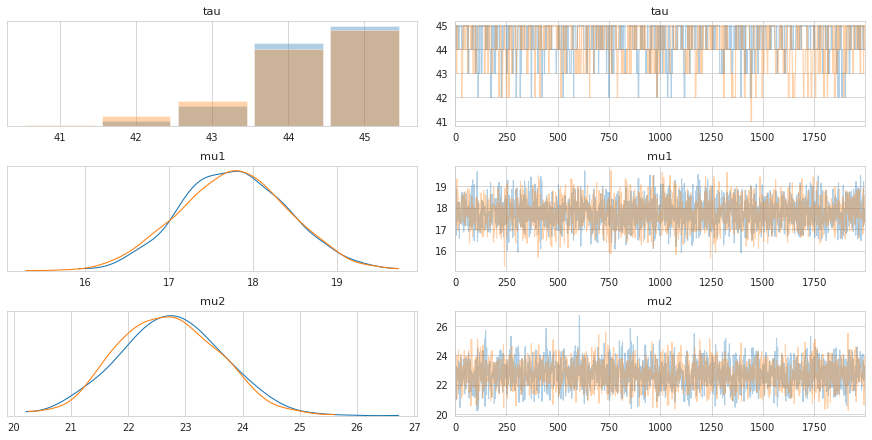

In [20]:
az.plot_trace(trace_chPoint_test);

Похоже, что ближе к 45-ому дню ситуация поменялась - вначале было примерно 18 сообщений в день, а после этого момента стало примерно 23.

# A/B testing 

Или A/B тестирование, популярное в маркетинге. Внедряется какое-то изменение и затем нужно выяснить, а изменилось ли что-то с этим внедрением. История за кадром: идет работа над страничкой с платежным шлюзом, есть два дизайна, в течении месяца пользователей шлют то туда то сюда в случайном порядке (GRP B, GRP  A). Вопрос в следующем, какой вариант лучше, насколько?  

In [0]:
ab_test = pd.read_csv('https://assets.datacamp.com/production/repositories/1646/datasets/2751adce60684a03d8b4132adeadab8a0b95ee56/AB_testing_exercise.csv')
ab_test.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A


Это задание ещё порешаю.